In [1]:
from fastai.text.all import *
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tqdm import tqdm

In [4]:
fp = open('positive_test_text', 'r')
all_positive_text = fp.read()
individual_positive_texts = all_positive_text.split('\n')

In [5]:
fn = open('negative_test_text', 'r')
all_negative_text = fn.read()
individual_negative_texts = all_negative_text.split('\n')

In [6]:
# neutral_model = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb")
positive_model = AutoModelForCausalLM.from_pretrained("/home/advaitmb/notebooks/projects/PreDiction/nbs/gpt2-imdb-positive-sentiment")
# negative_model = AutoModelForCausalLM.from_pretrained("/home/advaitmb/notebooks/projects/PreDiction/nbs/gpt2-imdb-negative-sentiment")

In [7]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [8]:
# neutral_model.to('cuda')
positive_model.to('cuda')
# negative_model.to('cuda')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [9]:
def clean_html(raw_html):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def clean_newlines(raw_text):
    return raw_text.replace('\n', '')

In [10]:
def generate_text_transformer(language_model, tokenizer, tokens, n_words_max=10):
    t = torch.LongTensor(tokens)[None].to('cuda')
    phrase = language_model.generate(input_ids=t, num_beams=5, temperature=1.2,  max_length=(len(tokens) + n_words_max), skip_special_tokens=True, do_sample=True, repetition_penalty=1.2)
    prediction = phrase[0][t.size(1):].cpu()
    prediction = prediction[prediction!=50256]
    return clean_newlines(clean_html(tokenizer.decode(prediction.numpy())[1:]))

In [11]:
all_test_texts = []
all_test_texts.extend(individual_positive_texts)
all_test_texts.extend(individual_negative_texts)

In [11]:
individual_positive_tokens = []
for text in tqdm(individual_positive_texts):
    text = text.strip()
    ids = tokenizer.encode(text)
    if len(ids)<1024:
        individual_positive_tokens.append(ids)

100%|██████████| 12501/12501 [00:17<00:00, 727.39it/s]


In [12]:
individual_negative_tokens = []
for text in tqdm(individual_negative_texts):
    text = text.strip()
    ids = tokenizer.encode(text)
    if len(ids)<1024:
        individual_negative_tokens.append(ids)

100%|██████████| 12501/12501 [00:15<00:00, 817.51it/s]


In [15]:
import random
random.choices??

In [13]:
all_text_tokens = []
all_text_tokens.extend(individual_positive_tokens[:500])
all_text_tokens.extend(individual_negative_tokens[:500])

In [16]:
pd.DataFrame??

In [14]:
pos_model_generations = []
failures = []
for token in tqdm(all_text_tokens):
    new_text = generate_text_transformer(positive_model, tokenizer, token)
    pos_model_generations.append(new_text)


  6%|▋         | 65/1000 [01:19<22:01,  1.41s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 20%|█▉        | 195/1000 [04:09<13:49,  1.03s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 32%|███▎      | 325/1000 [07:03<12:02,  1.07s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 46%|████▌     | 455/1000 [09:45<15:35,  1.72s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 58%|█████▊    | 585/1000 [12:34<08:34,  1.24s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 72%|███████▏  | 715/1000 [15:32<05:58,  1.26s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 84%|████████▍ | 845/1000 [18:28<04:29,  1.74s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 98%|█████████▊| 975/1000 [21:17<00:24,  1.03it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


100%|██████████| 1000/1000 [21:52<00:00,  1.31s/it]


In [15]:
np.save('./positive_generations_new.npy', np.array(pos_model_generations))

In [19]:
neg_model_generations = []
failures = []
for token in tqdm(all_text_tokens):
    new_text = generate_text_transformer(negative_model, tokenizer, token)
    neg_model_generations.append(new_text)


  6%|▋         | 65/1000 [01:21<22:41,  1.46s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 20%|█▉        | 195/1000 [04:16<14:12,  1.06s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 32%|███▎      | 325/1000 [07:15<12:51,  1.14s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 46%|████▌     | 455/1000 [10:00<15:59,  1.76s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 58%|█████▊    | 585/1000 [12:49<08:29,  1.23s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 72%|███████▏  | 715/1000 [15:46<06:03,  1.28s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 84%|████████▍ | 845/1000 [18:42<04:28,  1.73s/it]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 98%|█████████▊| 975/1000 [21:31<00:24,  1.02it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


100%|██████████| 1000/1000 [22:06<00:00,  1.33s/it]


In [20]:
np.save('./negative_generations.npy', np.array(neg_model_generations))

In [22]:
sentiment_model = AutoModelForSequenceClassification.from_pretrained("lvwerra/bert-imdb")
sentiment_tokenizer = AutoTokenizer.from_pretrained("lvwerra/bert-imdb")

In [24]:
text = 'this movie was really bad!!'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

(tensor([[ 3.6573, -4.2497]], grad_fn=<AddmmBackward>),)

In [43]:
output[0][0][1].item()

-4.392224311828613

In [34]:
pos_generations = list(np.load('./positive_generations_new.npy'))
neg_generations = list(np.load('./negative_generations.npy'))

In [44]:
sentiment_scores_pos_model = []
for generation in tqdm(pos_generations):
    output = sentiment_model.forward(sentiment_tokenizer.encode(generation, return_tensors="pt"))
    sentiment_scores_pos_model.append(output[0][0][1].item())

100%|██████████| 1000/1000 [01:21<00:00, 12.29it/s]


In [45]:
sentiment_scores_neg_model = []
for generation in tqdm(neg_generations):
    output = sentiment_model.forward(sentiment_tokenizer.encode(generation, return_tensors="pt"))
    sentiment_scores_neg_model.append(output[0][0][1].item())

100%|██████████| 1000/1000 [01:22<00:00, 12.19it/s]


In [46]:
data = {
    'positive model': sentiment_scores_pos_model,
    'negative model': sentiment_scores_neg_model
}

In [47]:
df = pd.DataFrame(data)

In [48]:
df.head()

,positive model,negative model
0,1.873373,2.374148
1,4.106321,-1.411491
2,4.269850,0.715142
3,2.061623,1.643730
4,4.185836,-1.465068


<AxesSubplot:>

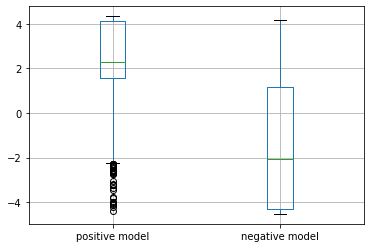

In [52]:
df.boxplot(column=['positive model', 'negative model'])

In [53]:
df.to_csv??

In [54]:
df.to_csv('sentiment_validation_results.csv')